# Experiments

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# company = "reit"
# company = "yellow_pages"
company = "calyxt"

test_pdf_path = f"../data/eval/{company}.pdf"

## Docling - strong!

In [3]:
# Potential for parallelization for files?
from docling.document_converter import DocumentConverter

# source = "https://arxiv.org/pdf/2408.09869"  # document per local path or URL
converter = DocumentConverter()
result = converter.convert(test_pdf_path)
print(result.document.export_to_markdown())

# REIT: execution for 7.4MB with 97 pages -> 5 min
# Yellow Pages: execution for 1.4MB with 77 pages -> 4 min
# Calyxt: execution for 0.7MB with 88 pages -> 3min

KeyboardInterrupt: 

In [ ]:
# domain knwoledge
# brackets in tables indicate negative values
# parsing issues (see current system prompt)

In [22]:
# Store as md with correct utf-8 encoding
with open(f"../dev/docling_{company}.md", "w", encoding="utf-8") as file:
    file.write(result.document.export_to_markdown())

## Custom Advanced Chunking

In [4]:
# Load markdown
with open(f"../dev/docling_{company}.md", "r", encoding="utf-8") as file:
    text = file.read()

In [5]:
# Analysis of chunk lengths if splitting by chapters
import re
import pandas as pd

chunks = re.split(r'(?m)(?=^#+\s)', text)
chunks_cleaned = [chunk for chunk in chunks if chunk.strip()]
char_counts = [len(chunk) for chunk in chunks_cleaned]

pd.Series(char_counts).describe()

count      271.000000
mean      1579.236162
std       2013.277228
min         11.000000
25%        284.000000
50%        980.000000
75%       2012.500000
max      17569.000000
dtype: float64

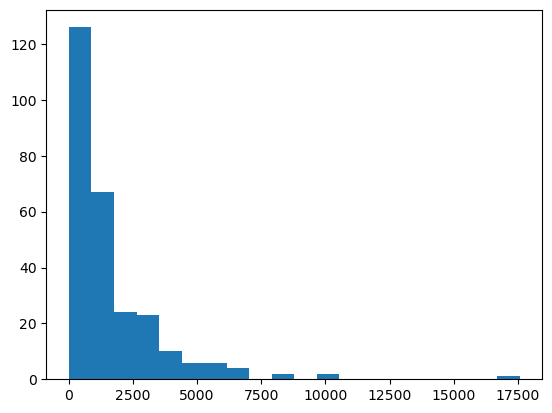

In [6]:
import matplotlib.pyplot as plt

plt.hist(char_counts, bins=20)
plt.show()

In [7]:
# Idea: Try to retrieve Table of Contents from PDF and attach to context first
# Then, chunk the document, attach as metadata the previous X section titles (retrieve via markdown) + page number?
# Split by chapters? If section too large, split into subsections with table correction?

In [8]:
import re

def is_table_paragraph(paragraph):
    """
    Returns True if the paragraph looks like a markdown table block.
    We assume that a table block consists of lines that begin with '|'
    and that at least one line is a separator (i.e. contains a series of dashes).
    """
    lines = paragraph.strip().splitlines()
    if not lines:
        return False
    if not all(line.lstrip().startswith('|') for line in lines):
        return False
    for line in lines:
        if re.search(r'\|\s*-{2,}', line):
            return True
    return False

def get_overlap_text(text, desired_overlap, max_overlap=None):
    """
    Extracts an overlap string from the end of `text` made up of whole words.

    Args:
        text (str): The text from which to extract the overlap.
        desired_overlap (int): Desired minimum number of characters to include in the overlap.
        max_overlap (int or None): Maximum allowed overlap (in characters). If None, no hard cap is applied.

    Returns:
        str: A string composed of whole words from the end of `text` whose total length
             is at least `desired_overlap` (if possible) but not exceeding `max_overlap` (if provided).
    """
    if max_overlap is None:
        max_overlap = desired_overlap * 2

    words = text.split()
    if not words:
        return ""

    overlap_words = []
    total_length = 0
    # Iterate over the words in reverse order.
    for word in reversed(words):
        # Add a space before each word except the first one we add.
        addition_length = len(word) if not overlap_words else len(word) + 1
        # If a maximum overlap is set and adding this word would exceed it,
        # then stop (unless no word has been added yet).
        if max_overlap is not None and total_length + addition_length > max_overlap:
            if overlap_words:
                break
            # Else, if even a single word is longer than max_overlap, add its characters until max is reached.
            if len(word) > max_overlap:
                overlap_words.append(word[:max_overlap - total_length])
                break
        overlap_words.append(word)
        total_length += addition_length
        # Stop if we've reached at least the desired overlap.
        if total_length >= desired_overlap:
            break

    # Reassemble the words in the correct order.
    return " ".join(reversed(overlap_words))

def split_paragraph(paragraph, max_chars, overlap_chars=0, max_overlap_chars=None):
    """
    Splits a non-table paragraph (by words) so that each part is below max_chars.
    If the paragraph is split into multiple parts, each subsequent part will begin with an
    overlap taken from the tail of the previous part. The overlap is composed of whole words,
    trying to reach at least `overlap_chars` characters but never exceeding `max_overlap_chars` (if set).

    Args:
        paragraph (str): The paragraph text to split.
        max_chars (int): Maximum allowed character length per part.
        overlap_chars (int): Desired number of characters to overlap between parts.
        max_overlap_chars (int or None): Absolute maximum allowed overlap (in characters).

    Returns:
        list of str: A list of paragraph parts, each no longer than max_chars.
    """
    words = paragraph.split()
    parts = []
    current = ""

    for word in words:
        candidate = (current + " " + word).strip() if current else word
        if len(candidate) > max_chars:
            # If we have accumulated some text, finalize it.
            if current:
                parts.append(current)
                # Compute an overlap from the end of current, as whole words.
                overlap_text = get_overlap_text(current, overlap_chars, max_overlap_chars) if overlap_chars > 0 else ""
                # Try to start the next segment with the overlap plus the current word.
                new_candidate = (overlap_text + " " + word).strip() if overlap_text else word
                if overlap_text and len(new_candidate) <= max_chars:
                    current = new_candidate
                else:
                    current = word
            else:
                # In the unlikely case a single word exceeds max_chars, yield it as its own part.
                parts.append(word)
                current = ""
        else:
            current = candidate
    if current:
        parts.append(current)
    return parts

def split_content(text, max_chars, overlap_chars=0, max_overlap_chars=None):
    """
    Split a block of text into parts no longer than max_chars.
    The text is first split into paragraphs (using double newlines) so that
    tables and other contiguous blocks remain intact. If an individual paragraph
    is too long and is not a table, it is further split with an overlap between parts.
    Also, for each final part a flag is computed (True/False) indicating whether the part is a table.

    Returns:
        tuple:
            - parts (list of str): The split parts.
            - is_table_ls (list of bool): For each part, True if it is a table block, False otherwise.
    """
    paragraphs = text.split("\n\n")
    parts = []
    is_table_ls = []  # This will store a True/False flag per part.

    current_part = ""
    current_part_is_table = None  # Will be set to True for table parts, False for non-table.

    for para in paragraphs:
        para = para.strip()
        if not para:
            continue

        para_is_table = is_table_paragraph(para)
        # If this paragraph is a table, do not merge with other content.
        if para_is_table:
            # TODO also include overlap to table!
            # TODO if table is larger then embedding model allows, split into smaller tables - how often does it happen?
            if current_part:
                parts.append(current_part)
                is_table_ls.append(current_part_is_table)
                current_part = ""
                current_part_is_table = None
            parts.append(para)
            is_table_ls.append(True)
            continue

        # For non-table paragraphs, if too long, split further.
        if len(para) > max_chars:
            sub_parts = split_paragraph(para, max_chars, overlap_chars, max_overlap_chars)
        else:
            sub_parts = [para]

        for sub in sub_parts:
            # If current_part is non-empty but from a different type (table vs. non-table), flush it.
            if current_part and current_part_is_table is not False:
                parts.append(current_part)
                is_table_ls.append(current_part_is_table)
                current_part = ""
                current_part_is_table = False

            candidate = (current_part + "\n\n" + sub).strip() if current_part else sub
            if len(candidate) <= max_chars:
                current_part = candidate
                current_part_is_table = False  # Non-table content.
            else:
                if current_part:
                    parts.append(current_part)
                    is_table_ls.append(current_part_is_table)
                current_part = sub
                current_part_is_table = False

    if current_part:
        parts.append(current_part)
        is_table_ls.append(current_part_is_table)

    return parts, is_table_ls

def chunk_markdown(markdown_text, document_name, context_window=2, max_chunk_size=2000, overlap_chars=500, max_overlap_chars=None):
    """
    Splits a markdown document into chunks based on headings and attaches metadata,
    including previous context_window section titles. If a section's content is too large,
    it is further split into sub‐chunks with an optional overlap (in characters) between
    consecutive parts.

    Args:
        markdown_text (str): The markdown document.
        context_window (int): Number of previous headings to include as context.
        max_chunk_size (int): Maximum allowed character length per (sub-)chunk.
        overlap_chars (int): Desired number of characters to overlap when splitting paragraphs (considering words).
        max_overlap_chars (int): Maximum allowed overlap between consecutive parts.

    Returns:
        list of dict: Each dict represents a (sub-)chunk and contains:
            - 'title': Heading text.
            - 'level': Heading level (number of '#' characters).
            - 'content': Content of the (sub-)chunk.
            - 'previous_titles': List of previous section titles.
            - 'part_index': Index of this part (1-based).
            - 'total_parts': Total number of parts for this section.
    """
    heading_pattern = re.compile(r'^(#{1,6})\s+(.*)$', re.MULTILINE)
    matches = list(heading_pattern.finditer(markdown_text))

    chunks = []

    # If no headings are found, treat the whole document as one chunk.
    if not matches:
        content_parts, is_table_ls = split_content(markdown_text.strip(), max_chunk_size, overlap_chars, max_overlap_chars)
        assert len(content_parts) == len(is_table_ls)
        total_parts = len(content_parts)
        for i, (part, is_table) in enumerate(zip(content_parts, is_table_ls), start=1):
            chunks.append({
                'title': None,
                'level': None,
                'table': is_table,
                'content': part,
                'previous_titles': [],
                'part_index': i,
                'total_parts': total_parts
            })
        return chunks

    # Process each section defined by a heading.
    for i, match in enumerate(matches):
        heading_marker = match.group(1)
        title = match.group(2).strip()
        level = len(heading_marker)

        # Determine content boundaries.
        content_start = match.end()
        content_end = matches[i+1].start() if i+1 < len(matches) else len(markdown_text)
        content = markdown_text[content_start:content_end].strip()

        previous_titles = [m.group(0).strip() for m in matches[max(0, i-context_window):i]]

        # Split the section's content if it's too large.
        content_parts, is_table_ls = split_content(content, max_chunk_size, overlap_chars, max_overlap_chars)
        assert len(content_parts) == len(is_table_ls), f"Lengths: {len(content_parts)} vs {len(is_table_ls)}"
        total_parts = len(content_parts)
        for j, (part, is_table) in enumerate(zip(content_parts, is_table_ls), start=1):
            chunk = {
                'title': title,
                'company': document_name,
                'level': level,
                'table': is_table,
                'previous_titles': previous_titles,
                'part_index': j,
                'total_parts': total_parts,
                'content': part,
            }
            chunks.append(chunk)
    return chunks

def pretty_print_chunks(chunks):
    for chunk in chunks:
        print("Title:", chunk['title'])
        print("Company:", chunk['company'])
        print("Level:", chunk['level'])
        print("Is Table:", chunk['table'])
        print("Part: {}/{}".format(chunk['part_index'], chunk['total_parts']))
        print("Previous Titles:", chunk['previous_titles'])
        print("Content:\n", chunk['content'])
        print("-" * 40)

# --- Example usage ---
sample_markdown = """
# Annual Report 2024

Introductory text for the report. This section contains some long descriptive text that might be very large and thus needs to be split into parts. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vestibulum vel dolor eget velit efficitur aliquet. Donec ullamcorper, metus ac convallis facilisis, lorem urna commodo nunc, nec facilisis velit leo et augue. Sed sodales, purus eget vulputate mollis, enim ipsum convallis magna, eget interdum urna arcu sit amet libero.

## Financial Overview

| For the years ended December 31,                                                                  | 2022         | 2021         |
|---------------------------------------------------------------------------------------------------|--------------|--------------|
| Cash flows from operating activities                                                              |              |              |
| Change in operating assets and liabilities                                                        | $  4,728     | $  26,154    |
| Stock-based compensation cash payments                                                            | (7,155)      | (5,541)      |
| Funding of post-employment benefit plans in excess of costs                                       | (32,106)     | (7,523)      |
| Income taxes paid, net                                                                            | (7,758)      | -            |
| Cash flows from operations, excluding the above                                                   | 91,791       | 91,489       |
|                                                                                                   | $  49,500    | $  104,579   |
| Cash flows used in investing activities                                                           |              |              |
| Additions to intangible assets                                                                    | $  (4,911)   | $  (4,957)   |
| Additions to property and equipment                                                               | (93)         | (117)        |
| Payments received from net investment in subleases                                                | 1,338        | 593          |
|                                                                                                   | $  (3,666)   | $  (4,481)   |
| Cash flows used in financing activities                                                           |              |              |
| Repayment of exchangeable debentures                                                              | $  -         | $  (107,033) |
| Repurchase of common shares through NCIBs                                                         | (12,404)     | (5,334)      |
| Repurchase of common shares per plan of arrangement, net of treasury shares and transaction costs | (96,125)     | -            |
| Issuance of common shares                                                                         | 153          | 111          |
| Payment of lease obligations                                                                      | (2,947)      | (3,045)      |
| Dividends paid                                                                                    | (14,163)     | (14,730)     |
|                                                                                                   | $  (125,486) | $  (130,031) |
| NET DECREASE IN CASH                                                                              | $  (79,652)  | $  (29,933)  |
| CASH, BEGINNING OF YEAR                                                                           | 123,559      | 153,492      |
| CASH, END OF YEAR                                                                                 | $  43,907    | $  123,559   |

Additional commentary follows the table to elaborate on the financial performance. More descriptive text is added to simulate a very large chunk that should be split intelligently. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Praesent ac nibh vestibulum, imperdiet orci sit amet, dictum urna.
"""

# For demonstration, set a lower max_chunk_size (e.g. 500 characters) and an overlap of 50 characters.
chunks = chunk_markdown(sample_markdown, company, context_window=3, max_chunk_size=200, overlap_chars=50, max_overlap_chars=100)

pretty_print_chunks(chunks)

# TODO also include overlap to table!

Title: Annual Report 2024
Company: calyxt
Level: 1
Is Table: False
Part: 1/3
Previous Titles: []
Content:
 Introductory text for the report. This section contains some long descriptive text that might be very large and thus needs to be split into parts. Lorem ipsum dolor sit amet, consectetur adipiscing
----------------------------------------
Title: Annual Report 2024
Company: calyxt
Level: 1
Is Table: False
Part: 2/3
Previous Titles: []
Content:
 Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vestibulum vel dolor eget velit efficitur aliquet. Donec ullamcorper, metus ac convallis facilisis, lorem urna commodo nunc, nec facilisis
----------------------------------------
Title: Annual Report 2024
Company: calyxt
Level: 1
Is Table: False
Part: 3/3
Previous Titles: []
Content:
 convallis facilisis, lorem urna commodo nunc, nec facilisis velit leo et augue. Sed sodales, purus eget vulputate mollis, enim ipsum convallis magna, eget interdum urna arcu sit amet libero.
------------

In [33]:
# Chunk sample
sample = text[:10000]

chunks = chunk_markdown(sample, company, context_window=3, max_chunk_size=2000, overlap_chars=500)

pretty_print_chunks(chunks)

Title: UNITED STATES SECURITIES AND EXCHANGE COMMISSION
Company: calyxt
Level: 2
Is Table: False
Part: 1/1
Previous Titles: []
Content:
 Washington, D.C. 20549
----------------------------------------
Title: FORM 10-K
Company: calyxt
Level: 2
Is Table: False
Part: 1/1
Previous Titles: ['## UNITED STATES SECURITIES AND EXCHANGE COMMISSION']
Content:
 <!-- image -->

(Mark One)

☒

ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF

1934

For the fiscal year ended December 31, 2022;

or

☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the transition period from                       to

Commission file number 001-38161
----------------------------------------
Title: Calyxt, Inc.
Company: calyxt
Level: 2
Is Table: False
Part: 1/2
Previous Titles: ['## UNITED STATES SECURITIES AND EXCHANGE COMMISSION', '## FORM 10-K']
Content:
 (Exact name of registrant as specified in its charter)

Delaware (State or other jurisd

In [26]:
len(chunks)

9

## Create embeddings

In [48]:
# OPENAI EMBEDDINGS

from openai import OpenAI
embedding_client = OpenAI()

# Max input: 8191 tokens

# embedding_model = "text-embedding-3-large"
# embedding_size = 3072

embedding_model = "text-embedding-3-small"
embedding_size = 1536

contents = [f"{chunk['title']} - {chunk['content']}" for chunk in chunks]
contents_cleaned = [txt.replace("\n", " ") for txt in contents]
embeddings = embedding_client.embeddings.create(input=contents_cleaned, model=embedding_model).data

# extract embeddings and attach to chunks
# for i, chunk in enumerate(chunks):
#     chunk["embedding"] = embeddings[i].embedding

# for chunk in chunks:
#     chunk["embedding"] = get_embedding(chunk["content"], embedding_model)
embeddings = [emb.embedding for emb in embeddings]

In [155]:
# LOCAL APPROACH
from sentence_transformers import SentenceTransformer

# Initialize the pre-trained model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embedding_size = 384

# TODO make this more sophisticated, to include metadata in embedding
contents = [f"{chunk['title']} - {chunk['content']}" for chunk in chunks]
contents_cleaned = [txt.replace("\n", " ") for txt in contents]

# Generate the embedding
embeddings = embedding_model.encode(contents_cleaned)
embeddings = [emb.tolist() for emb in embeddings]

In [38]:
# attach to chunks
db_data = []
for idx, chunk in enumerate(chunks):
    db_data.append({
        "embedding": embeddings[idx],
        "metadata": chunk,
    })

In [45]:
db_data[6]["metadata"]

{'title': 'Table of Contents',
 'company': 'calyxt',
 'level': 2,
 'table': True,
 'previous_titles': ['## FORM 10-K',
  '## Calyxt, Inc.',
  '## DOCUMENTS INCORPORATED BY REFERENCE'],
 'part_index': 2,
 'total_parts': 2,
 'content': "| PART I   |                                                                                                              |    |\n|----------|--------------------------------------------------------------------------------------------------------------|----|\n| Item 1.  | Business                                                                                                     |    |\n| Item 1A. | Risk Factors                                                                                                 | 12 |\n| Item 1B. | Unresolved Staff Comments                                                                                    | 26 |\n| Item 2.  | Properties                                                                                            

## Creating vector database

In [159]:
chunk.keys()

dict_keys(['title', 'level', 'previous_titles', 'part_index', 'total_parts', 'content'])

In [65]:
# https://qdrant.tech/documentation/beginner-tutorials/search-beginners/

from qdrant_client import models, QdrantClient

# Connect to Qdrant
# TODO store locally!
# client = QdrantClient(host="localhost", port=6333)
client = QdrantClient(":memory:")

# Define collection parameters
collection_name = "rag_test_db"
# embedding_size = 384

client.create_collection(
    collection_name=collection_name,
    vectors_config=models.VectorParams(
            size=embedding_size,
            distance=models.Distance.COSINE  # or Distance.EUCLID, etc.
        )
)

client.upload_points(
    collection_name=collection_name,
    points=[
        models.PointStruct(id=idx, vector=data["embedding"], payload=data["metadata"])
        for idx, data in enumerate(db_data)
    ],
)

ResponseHandlingException: [WinError 10061] No connection could be made because the target machine actively refused it

## Retrieving from vector DB

In [63]:
# demo_query = "For which year is the report?"
demo_query = "What is chapter 3 about?"

# demo_query_embedding = embedding_model.encode(demo_query).tolist()

demo_query_embedding = embedding_client.embeddings.create(input=demo_query, model=embedding_model).data[0].embedding

In [64]:
# https://qdrant.tech/documentation/beginner-tutorials/search-beginners/

# collection_name = "rag_test_db"

hits = client.query_points(
    collection_name=collection_name,
    query=demo_query_embedding,
    limit=3  # number of top results
).points

# https://qdrant.tech/documentation/concepts/filtering/
# hits = client.query_points(
#     collection_name=collection_name,
#     query=demo_query_embedding,
#     query_filter=models.Filter(
#         must=[models.FieldCondition(key="year", range=models.Range(gte=2000))]
#     ),
#     limit=1,
# ).points


for hit in hits:
    print(hit.payload, "score:", hit.score)

{'title': 'Table of Contents', 'company': 'calyxt', 'level': 2, 'table': False, 'previous_titles': ['## FORM 10-K', '## Calyxt, Inc.', '## DOCUMENTS INCORPORATED BY REFERENCE'], 'part_index': 1, 'total_parts': 2, 'content': '3\n\n3\n\nTable of Contents'} score: 0.43792482557264567
{'title': 'Table of Contents', 'company': 'calyxt', 'level': 2, 'table': True, 'previous_titles': ['## FORM 10-K', '## Calyxt, Inc.', '## DOCUMENTS INCORPORATED BY REFERENCE'], 'part_index': 2, 'total_parts': 2, 'content': "| PART I   |                                                                                                              |    |\n|----------|--------------------------------------------------------------------------------------------------------------|----|\n| Item 1.  | Business                                                                                                     |    |\n| Item 1A. | Risk Factors                                                                               

## Not working well

### PyMuPDF4LLM - tables bad

In [ ]:
## Observations
# tables are pretty bad
# format in general seems ok

In [6]:
# Store as file
import pathlib
pathlib.Path("../dev/pymupdf4llm_output.md").write_bytes(md_text.encode())

261957

In [5]:
md_text[:1000]

'-----\n\n# Table of Contents\n\nManagement’s Discussion and Analysis........................................................................................................ 2\n\nIndependent Auditor’s Report ................................................................................................................. 29-32\n\nConsolidated Statements of Income and Other Comprehensive Income ..................................................... 33\n\nConsolidated Statements of Financial Position ............................................................................................ 34\n\nConsolidated Statements of Changes in Equity ...................................................................................... 35-36\n\nConsolidated Statements of Cash Flows ..................................................................................................... 37\n\nNotes To The Consolidated Financial Statements .................................................................

### Camelot (table detection) - Not working well

In [ ]:
import camelot

# Extract tables from all pages of the PDF
tables = camelot.read_pdf(test_pdf_path, pages="all")

# Export each table to CSV (or process further as needed)
for i, table in enumerate(tables):
    csv_filename = f"table_{i}.csv"
    table.to_csv(csv_filename)
    print(f"Exported table {i} to {csv_filename}")
